In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

%cd /content/drive/MyDrive/University/Code/CNN practice/data35

Mounted at /content/drive
/content/drive/MyDrive/University/Code/CNN practice/data35


In [ ]:
import os
from keras.models import Model
from keras.optimizers import Adam
import tensorflow as tf
from keras.applications import ConvNeXtLarge, ConvNeXtTiny
from keras.applications.convnext import preprocess_input
# from keras.applications.vgg19 import VGG19, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten
from keras import regularizers
from pathlib import Path
import numpy as np

In [ ]:
pwd

'/content/drive/MyDrive/University/Code/CNN practice/datasetFull'

In [ ]:
!pip install livelossplot --quiet

In [ ]:
from livelossplot.inputs.keras import PlotLossesCallback

tl_checkpoint = ModelCheckpoint(filepath='model.hdf5',
                                  save_weights_only=True,
                                  monitor='val_accuracy',
                                  mode='max',
                                  save_best_only=True)

early_stop = EarlyStopping(monitor='val_loss',
                           patience=50,
                           restore_best_weights=True,
                           mode='min')

# Classifier Report

In [ ]:
from sklearn.metrics import roc_curve, auc, roc_auc_score, classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def ploat_ROC(y_true, y_score, title):
  fpr = dict()
  tpr = dict()
  roc_auc = dict()

  for i in range(y_score.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(y_true == i, y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

  plt.figure(figsize=(8, 5))
  colors = ['blue', 'red', 'green']
  for i, color in zip(range(y_score.shape[1]), colors):
      plt.plot(fpr[i], tpr[i], color=color, lw=2,
              label='ROC curve of class {0} (area = {1:0.2f})'
              ''.format(i, roc_auc[i]))

  plt.plot([0, 1], [0, 1], 'k--', lw=2)
  plt.xlim([-0.05, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title( title +' (one-vs-rest)')
  plt.legend(loc="lower right")
  plt.show()

def ploat_confusionMatrix(y_true, y_predict, title):
  conf_mat = confusion_matrix(y_true, y_predict)
  # print("Confusion matrix:\n", conf_mat)

  # Print confusion matrix as heatmap
  sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='g')
  plt.xlabel('Predicted label')
  plt.ylabel('True label')
  plt.title(title)
  plt.show()

def ploat_AUC(y_true, y_score, title):
  n_classes = y_score.shape[1]
  fpr = dict()
  tpr = dict()
  roc_auc = dict()

  # Compute ROC curve and ROC area for each class
  for i in range(n_classes):
      fpr[i], tpr[i], _ = roc_curve(y_true, y_score[:, i], pos_label=i)
      roc_auc[i] = auc(fpr[i], tpr[i])

  # Plot all ROC curves
  plt.figure()
  lw = 2
  colors = ['darkorange', 'cornflowerblue', 'purple']
  for i, color in zip(range(n_classes), colors):
      plt.plot(fpr[i], tpr[i], color=color, lw=lw,
              label='ROC curve of class {0} (AUC = {1:0.2f})'
              ''.format(i, roc_auc[i]))

  plt.plot([0, 1], [0, 1], 'k--', lw=lw)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC for ' + title )
  plt.legend(loc="lower right")
  plt.show()


def ploat_AUC_per_class(y_true, y_score, title):
  # compute AUC for each class
  n_classes = y_score.shape[1]
  auc_list = []
  for i in range(n_classes):
      auc = roc_auc_score(y_true == i, y_score[:, i])
      auc_list.append(auc)

  # plot AUC curve for class 0
  fpr, tpr, _ = roc_curve(y_true == 0, y_score[:, 0])
  plt.plot(fpr, tpr, label='Class 0 (AUC = %0.2f)' % auc_list[0])

  # set plot properties
  plt.plot([0, 1], [0, 1], 'k--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(title)
  plt.legend(loc="lower right")

  plt.show()

def classificationReport(y_true, y_pred, title):
  print('Classification report for ' + title)
  print('\n')
  target_names = ['class 0', 'class 1', 'class 2']
  print(classification_report(y_true, y_pred, target_names=target_names))

# Augmentation

In [ ]:
BATCH_SIZE = 65
train_generator = ImageDataGenerator(rotation_range=45,
                                     brightness_range=[0.1, 0.9],
                                     width_shift_range=0.1,
                                     height_shift_range=0.15,
                                     horizontal_flip=True,
                                     vertical_flip=True,
                                     shear_range=20.0,
                                    #  validation_split=0.30,
                                     fill_mode='nearest',
                                     featurewise_center=False,
                                     samplewise_center=False,
                                     preprocessing_function=preprocess_input)

test_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

train_data_dir = 'train'
test_data_dir = 'test'
validation_data_dir = 'valid'

In [ ]:
traingen = train_generator.flow_from_directory(train_data_dir,
                                               target_size=(512, 512),
                                               class_mode='categorical',
                                               classes=None,
                                              #  subset='training',
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               seed=42)

validgen = train_generator.flow_from_directory(validation_data_dir,
                                               target_size=(512, 512),
                                               class_mode='categorical',
                                               classes=None,
                                              #  subset='validation',
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               seed=42)

testgen = test_generator.flow_from_directory(test_data_dir,
                                             target_size=(512, 512),
                                             class_mode=None,
                                             classes=None,
                                             batch_size=1,
                                             shuffle=False,
                                             seed=42)

Found 105 images belonging to 3 classes.
Found 30 images belonging to 3 classes.
Found 44 images belonging to 3 classes.


In [ ]:
input_shape = (512, 512, 3)
n_classes=3

n_steps = traingen.samples // BATCH_SIZE
n_val_steps = validgen.samples // BATCH_SIZE
n_epochs = 100

optimizer = Adam(learning_rate=0.0001)

# ConvNeXtLarge

In [ ]:
def create_model(input_shape, n_classes, optimizer='rmsprop', fine_tune=0):

    conv_base = ConvNeXtLarge(
                     model_name="convnext_large",
                     include_top=False,
                     include_preprocessing=True,
                     weights='imagenet',
                     input_tensor=None,
                     input_shape=input_shape,
                     pooling='max',
                     classifier_activation="softmax",)

    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    top_model = conv_base.output
    top_model = Flatten(name="flatten")(top_model)
    top_model = Dense(2098, activation='relu',kernel_regularizer=regularizers.L2(0.01))(top_model)
    top_model = tf.keras.layers.BatchNormalization()(top_model)
    top_model = Dropout(0.5)(top_model)

    top_model = Dense(2098, activation='relu',kernel_regularizer=regularizers.L2(0.01))(top_model)
    top_model = tf.keras.layers.BatchNormalization()(top_model)
    top_model = Dropout(0.5)(top_model)

    output_layer = Dense(n_classes, activation='softmax')(top_model)
    model = Model(inputs=conv_base.input, outputs=output_layer)

    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [ ]:
ConvNeXtLarge_model_ft = create_model(input_shape, n_classes, optimizer, fine_tune=3)

785596384/785596384 [==============================] - 4s 0us/step


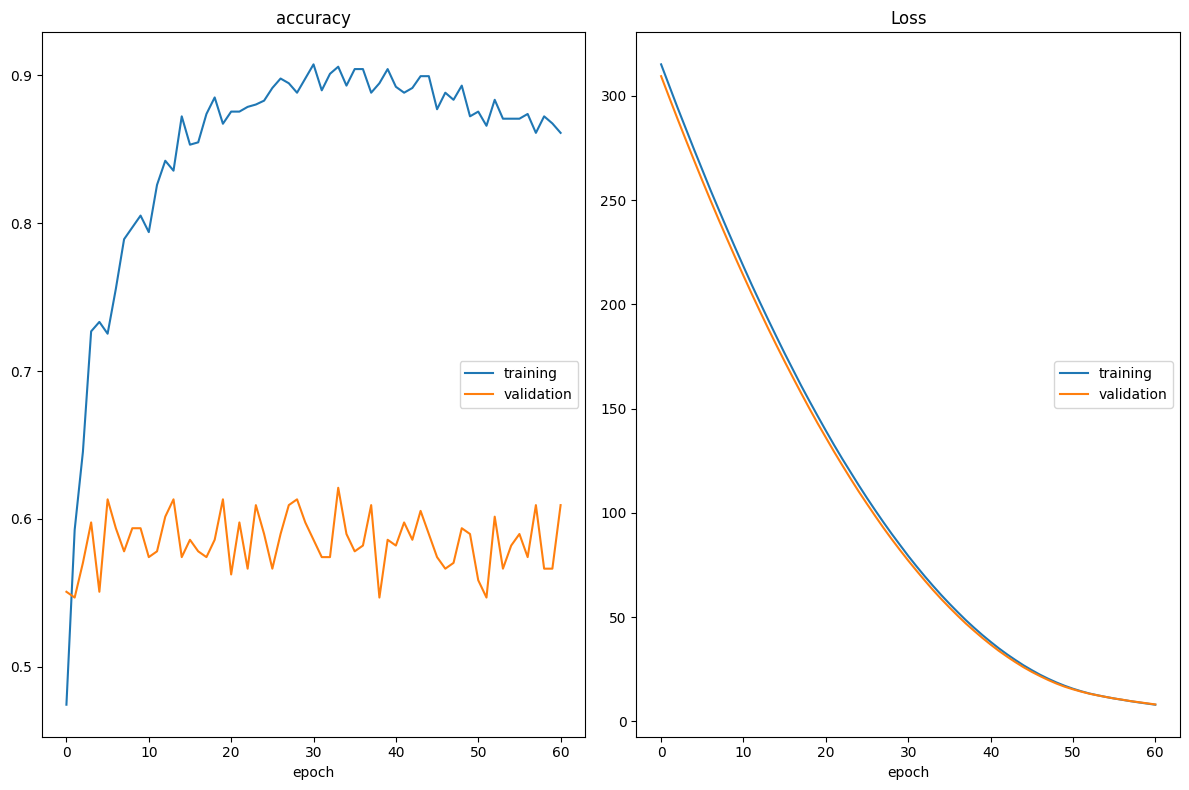

accuracy
	training         	 (min:    0.474, max:    0.907, cur:    0.861)
	validation       	 (min:    0.547, max:    0.621, cur:    0.609)
Loss
	training         	 (min:    8.031, max:  315.080, cur:    8.031)
	validation       	 (min:    8.153, max:  309.412, cur:    8.153)
10/10 [==============================] - 160s 16s/step - loss: 8.0313 - accuracy: 0.8610 - val_loss: 8.1526 - val_accuracy: 0.6094
Epoch 62/150
 5/10 [==============>...............] - ETA: 54s - loss: 7.6282 - accuracy: 0.8844 

In [ ]:
%%time

plot_loss = PlotLossesCallback()

ConvNeXtLarge_ft_history = ConvNeXtLarge_model_ft.fit(traingen,
                                  batch_size=BATCH_SIZE,
                                  epochs=n_epochs,
                                  validation_data=validgen,
                                  steps_per_epoch=n_steps,
                                  validation_steps=n_val_steps,
                                  callbacks=[tl_checkpoint, early_stop, plot_loss],
                                  verbose=1)

In [ ]:
ConvNeXtLarge_model_ft.load_weights('ConvNeXtLarge.hdf5')

true_classes = testgen.classes
class_indices = traingen.class_indices

class_indices = dict((v,k) for k,v in class_indices.items())

ConvNeXtLarge_preds_ft = ConvNeXtLarge_model_ft.predict(testgen)
ConvNeXtLarge_pred_classes_ft = np.argmax(ConvNeXtLarge_preds_ft, axis=1)


108/108 [==============================] - 1596s 15s/step


In [ ]:
from sklearn.metrics import accuracy_score

ConvNeXtLarge_acc_ft = accuracy_score(true_classes, ConvNeXtLarge_pred_classes_ft)
print("ConvNeXtLarge Test Accuracy : {:.2f}%".format(ConvNeXtLarge_acc_ft * 100))

ConvNeXtLarge Test Accuracy : 75.93%


Classification report for ConvNeXtLarge


              precision    recall  f1-score   support

     class 0       0.75      0.91      0.82        53
     class 1       0.68      0.58      0.62        26
     class 2       0.86      0.66      0.75        29

    accuracy                           0.76       108
   macro avg       0.77      0.71      0.73       108
weighted avg       0.76      0.76      0.75       108





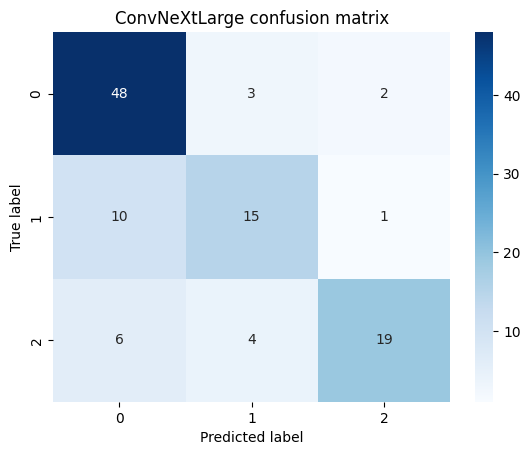

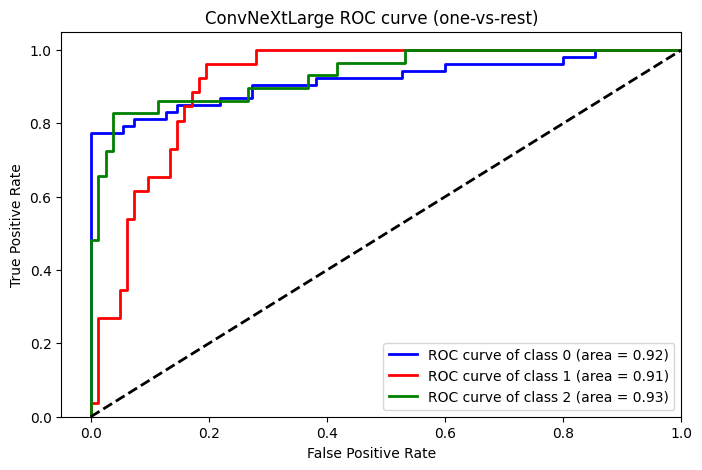

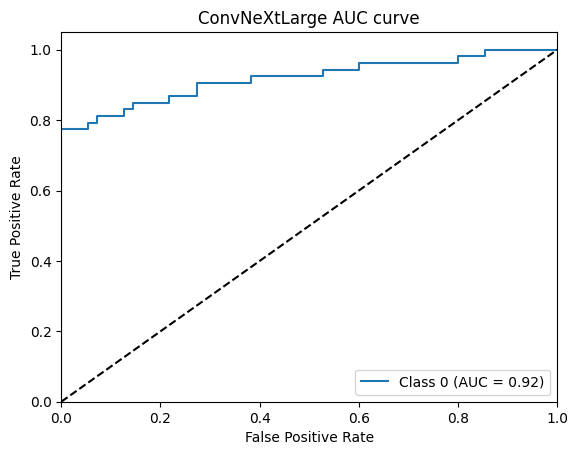

In [ ]:
classificationReport(true_classes, ConvNeXtLarge_pred_classes_ft, 'ConvNeXtLarge')
print('\n')
ploat_confusionMatrix(true_classes, ConvNeXtLarge_pred_classes_ft, 'ConvNeXtLarge confusion matrix')
print('\n')
ploat_ROC(true_classes, ConvNeXtLarge_preds_ft, "ConvNeXtLarge ROC curve")
print('\n')
ploat_AUC(true_classes, ConvNeXtLarge_preds_ft, "ConvNeXtLarge AUC curve")

# ConvNeXtBase

In [ ]:
from keras.applications import ConvNeXtBase
from keras.applications.convnext import preprocess_input

In [ ]:
def create_model_ConvNeXtBase(input_shape, n_classes, optimizer='rmsprop', fine_tune=0):

    conv_base = ConvNeXtBase(
                     model_name="convnext_base",
                     include_top=False,
                     include_preprocessing=True,
                     weights='imagenet',
                     input_tensor=None,
                     input_shape=input_shape,
                     pooling='max',
                     classifier_activation="softmax",)

    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    top_model = conv_base.output
    top_model = Flatten(name="flatten")(top_model)
    top_model = Dense(2098, activation='relu',kernel_regularizer=regularizers.L2(0.01))(top_model)
    top_model = tf.keras.layers.BatchNormalization()(top_model)
    top_model = Dropout(0.5)(top_model)

    top_model = Dense(2098, activation='relu',kernel_regularizer=regularizers.L2(0.01))(top_model)
    top_model = tf.keras.layers.BatchNormalization()(top_model)
    top_model = Dropout(0.5)(top_model)

    output_layer = Dense(n_classes, activation='softmax')(top_model)
    model = Model(inputs=conv_base.input, outputs=output_layer)

    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [ ]:
ConvNeXtBase_model_ft = create_model_ConvNeXtBase(input_shape, n_classes, optimizer, fine_tune=3)

350926856/350926856 [==============================] - 16s 0us/step


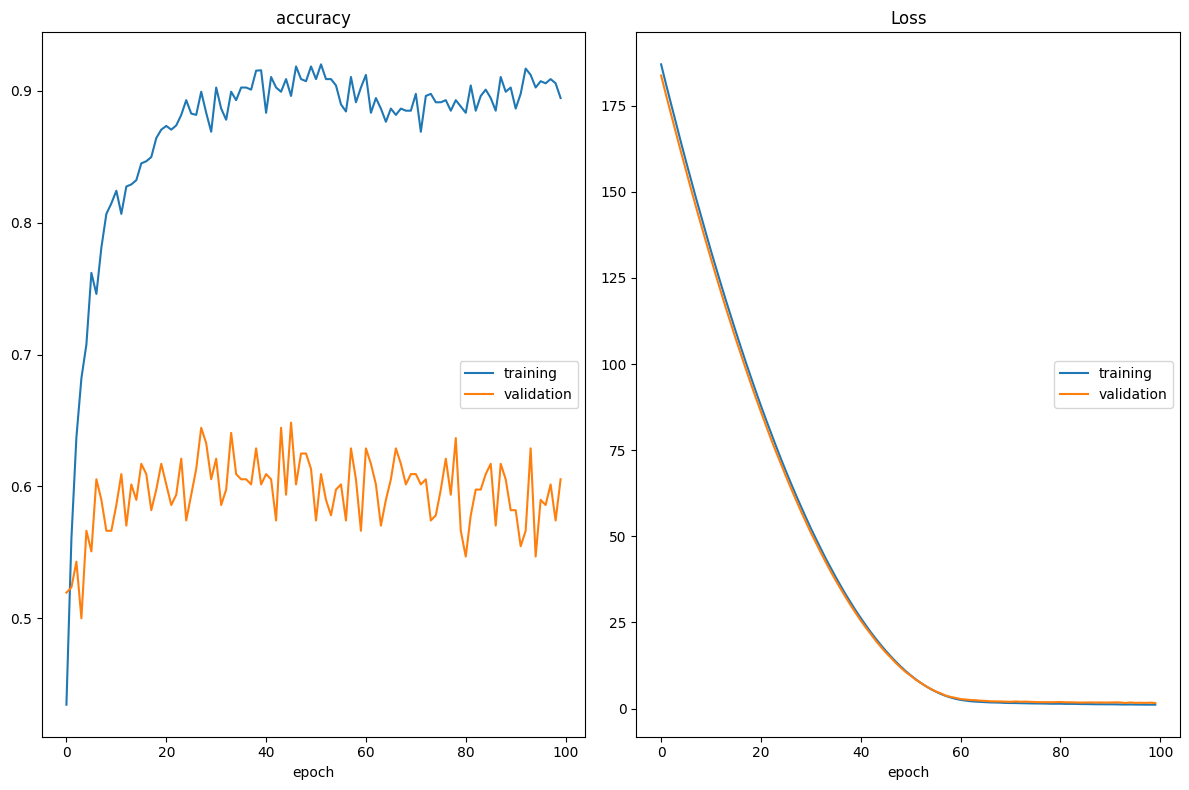

accuracy
	training         	 (min:    0.435, max:    0.920, cur:    0.895)
	validation       	 (min:    0.500, max:    0.648, cur:    0.605)
Loss
	training         	 (min:    1.102, max:  187.030, cur:    1.102)
	validation       	 (min:    1.590, max:  183.789, cur:    1.590)
10/10 [==============================] - 104s 10s/step - loss: 1.1022 - accuracy: 0.8946 - val_loss: 1.5901 - val_accuracy: 0.6055


In [ ]:
%%time

plot_loss = PlotLossesCallback()

ConvNeXtBase_ft_history = ConvNeXtBase_model_ft.fit(traingen,
                                  batch_size=BATCH_SIZE,
                                  epochs=n_epochs,
                                  validation_data=validgen,
                                  steps_per_epoch=n_steps,
                                  validation_steps=n_val_steps,
                                  callbacks=[tl_checkpoint, early_stop, plot_loss],
                                  verbose=1)

In [ ]:
ConvNeXtBase_model_ft.load_weights('model.hdf5')

true_classes = testgen.classes
class_indices = traingen.class_indices

class_indices = dict((v,k) for k,v in class_indices.items())

ConvNeXtBase_preds_ft = ConvNeXtBase_model_ft.predict(testgen) #ConvNeXtBase_preds_ft is the predicted probabilities for each class
ConvNeXtBase_pred_classes_ft = np.argmax(ConvNeXtBase_preds_ft, axis=1) # ConvNeXtBase_pred_classes_ft is the selected class from the probabilities

108/108 [==============================] - 13s 122ms/step


In [ ]:
from sklearn.metrics import accuracy_score
ConvNeXtBase_acc_ft = accuracy_score(true_classes, ConvNeXtBase_pred_classes_ft)
print("ConvNeXtBase Test Accuracy : {:.2f}%".format(ConvNeXtBase_acc_ft * 100))

ConvNeXtBase Test Accuracy : 83.33%


Classification report for ConvNeXtBase


              precision    recall  f1-score   support

     class 0       0.85      0.89      0.87        53
     class 1       0.71      0.85      0.77        26
     class 2       0.95      0.72      0.82        29

    accuracy                           0.83       108
   macro avg       0.84      0.82      0.82       108
weighted avg       0.85      0.83      0.83       108





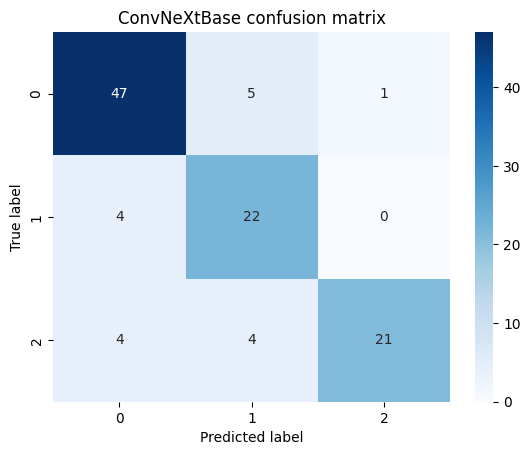

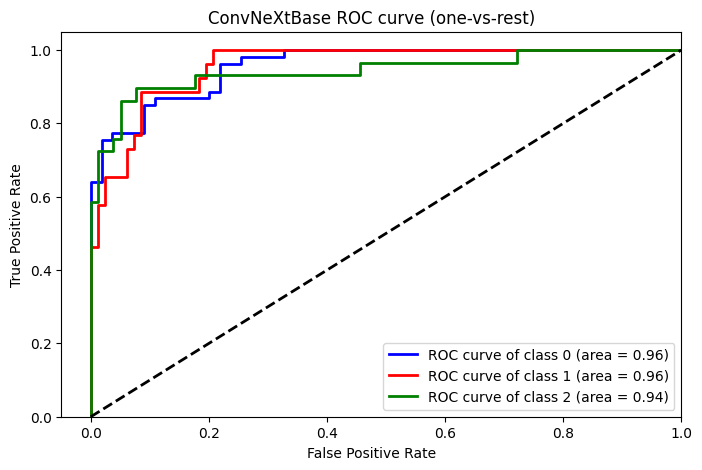

In [ ]:
classificationReport(true_classes, ConvNeXtBase_pred_classes_ft, 'ConvNeXtBase')
print('\n')
ploat_confusionMatrix(true_classes, ConvNeXtBase_pred_classes_ft, 'ConvNeXtBase confusion matrix')
print('\n')
ploat_ROC(true_classes, ConvNeXtBase_preds_ft, "ConvNeXtBase ROC curve")
# print('\n')
# ploat_AUC(true_classes, ConvNeXtBase_preds_ft, "ConvNeXtBase AUC curve")

# ConvNeXtXLarge

In [ ]:
from keras.applications import ConvNeXtXLarge

In [ ]:
def create_model_convnext_xlarge(input_shape, n_classes, optimizer='rmsprop', fine_tune=0):

    conv_base = ConvNeXtXLarge(
                     model_name="convnext_xlarge",
                     include_top=False,
                     include_preprocessing=True,
                     weights='imagenet',
                     input_tensor=None,
                     input_shape=input_shape,
                     pooling='max',
                     classifier_activation="softmax",)

    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    top_model = conv_base.output
    top_model = Flatten(name="flatten")(top_model)
    top_model = Dense(2098, activation='relu',kernel_regularizer=regularizers.L2(0.01))(top_model)
    top_model = tf.keras.layers.BatchNormalization()(top_model)
    top_model = Dropout(0.5)(top_model)

    top_model = Dense(2098, activation='relu',kernel_regularizer=regularizers.L2(0.01))(top_model)
    top_model = tf.keras.layers.BatchNormalization()(top_model)
    top_model = Dropout(0.5)(top_model)

    output_layer = Dense(n_classes, activation='softmax')(top_model)
    model = Model(inputs=conv_base.input, outputs=output_layer)

    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [ ]:
convnext_xlarge_model_ft = create_model_convnext_xlarge(input_shape, n_classes, optimizer, fine_tune=3)

1393257616/1393257616 [==============================] - 10s 0us/step


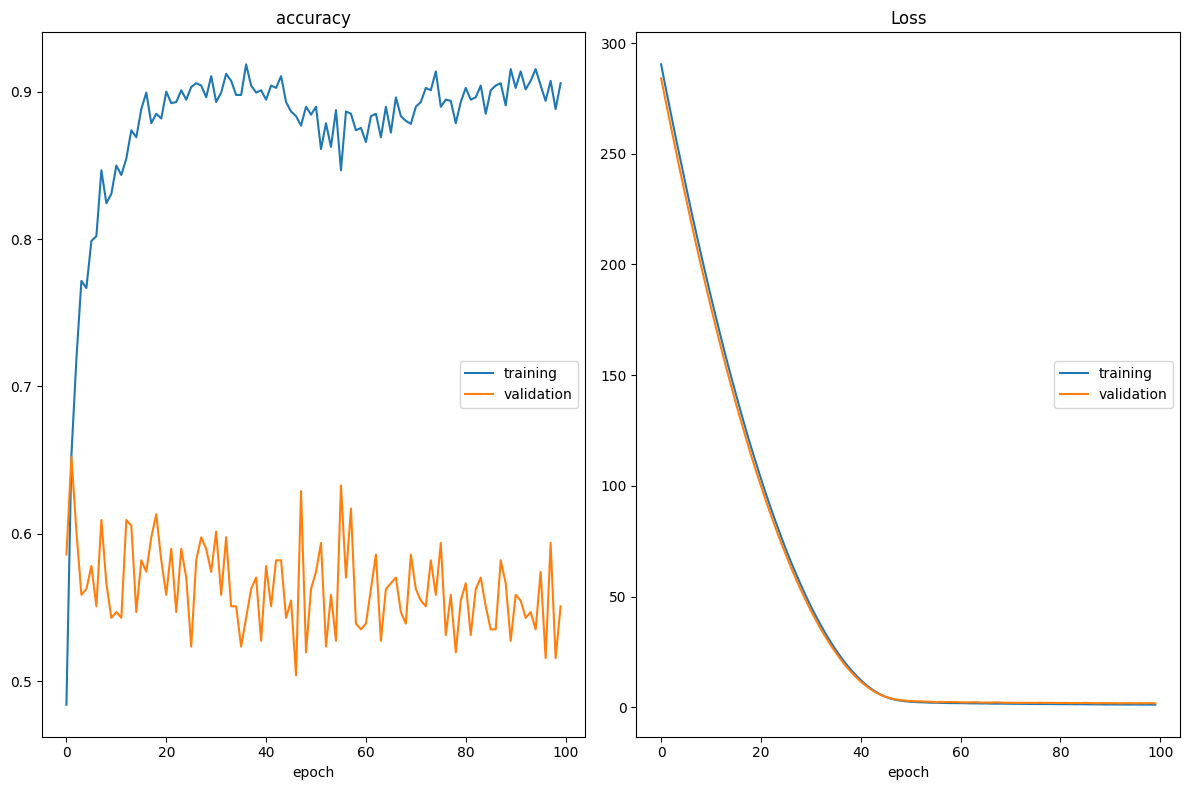

accuracy
	training         	 (min:    0.484, max:    0.919, cur:    0.906)
	validation       	 (min:    0.504, max:    0.652, cur:    0.551)
Loss
	training         	 (min:    1.151, max:  290.362, cur:    1.151)
	validation       	 (min:    1.745, max:  284.054, cur:    1.766)
10/10 [==============================] - 61s 6s/step - loss: 1.1511 - accuracy: 0.9058 - val_loss: 1.7659 - val_accuracy: 0.5508
CPU times: user 1h 17min 34s, sys: 6min 8s, total: 1h 23min 43s
Wall time: 2h 7min 13s


In [ ]:
%%time

plot_loss = PlotLossesCallback()

convnext_xlarge_ft_history = convnext_xlarge_model_ft.fit(traingen,
                                  batch_size=BATCH_SIZE,
                                  epochs=n_epochs,
                                  validation_data=validgen,
                                  steps_per_epoch=n_steps,
                                  validation_steps=n_val_steps,
                                  callbacks=[tl_checkpoint, early_stop, plot_loss],
                                  verbose=1)

In [ ]:
convnext_xlarge_model_ft.load_weights('convnext_xlarge.hdf5')

true_classes = testgen.classes
class_indices = traingen.class_indices

class_indices = dict((v,k) for k,v in class_indices.items())

convnext_xlarge_preds_ft = convnext_xlarge_model_ft.predict(testgen)
convnext_xlarge_pred_classes_ft = np.argmax(convnext_xlarge_preds_ft, axis=1)

108/108 [==============================] - 45s 263ms/step


In [ ]:
from sklearn.metrics import accuracy_score
convnext_xlarge_acc_ft = accuracy_score(true_classes, convnext_xlarge_pred_classes_ft)
print("convnext_xlarge Test Accuracy : {:.2f}%".format(convnext_xlarge_acc_ft * 100))

convnext_xlarge Test Accuracy : 54.63%


Classification report for convnext_xlarge


              precision    recall  f1-score   support

     class 0       0.52      1.00      0.68        53
     class 1       1.00      0.04      0.07        26
     class 2       1.00      0.17      0.29        29

    accuracy                           0.55       108
   macro avg       0.84      0.40      0.35       108
weighted avg       0.76      0.55      0.43       108





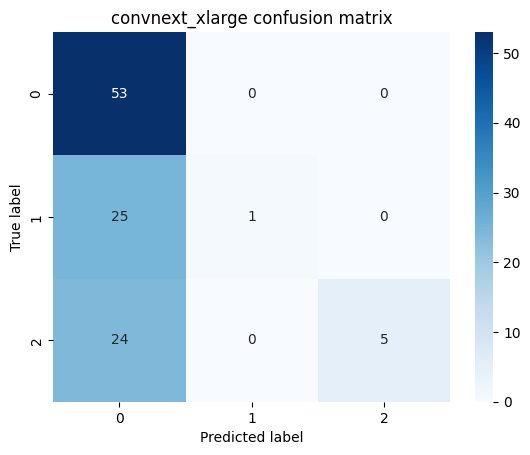

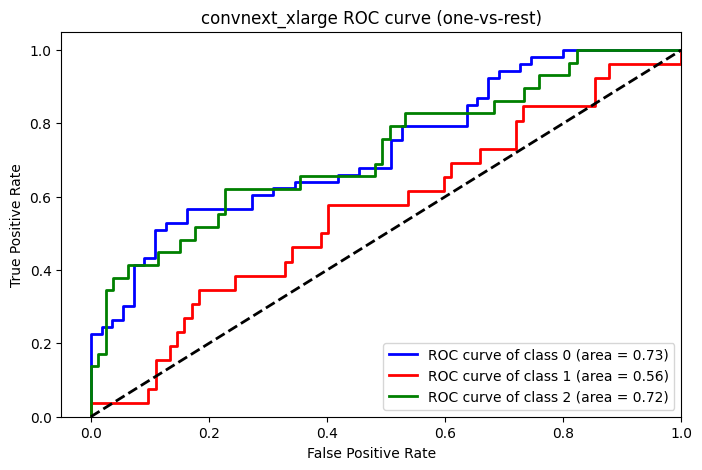

In [ ]:
classificationReport(true_classes, convnext_xlarge_pred_classes_ft, 'convnext_xlarge')
print('\n')
ploat_confusionMatrix(true_classes, convnext_xlarge_pred_classes_ft, 'convnext_xlarge confusion matrix')
print('\n')
ploat_ROC(true_classes, convnext_xlarge_preds_ft, "convnext_xlarge ROC curve")

# Tune Hyperparameter

In [ ]:
train_labels = traingen.classes
val_labels = validgen.classes
val_data = validgen
train_data = traingen

In [ ]:
pip install keras-tuner --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 5.7 MB/s eta 0:00:00


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch
from keras.applications import ConvNeXtBase

<ipython-input-10-0136de22b5de>:3: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [ ]:
input_shape = (256, 256, 3)
n_classes=3

n_steps = traingen.samples // BATCH_SIZE
n_val_steps = validgen.samples // BATCH_SIZE
n_epochs = 48

optimizer = Adam(learning_rate=0.0001)

In [ ]:
def tune_ConvNeXtBase(hp):

    conv_base = ConvNeXtBase(
                     model_name="convnext_base",
                     include_top=False,
                     include_preprocessing=True,
                     weights='imagenet',
                     input_tensor=None,
                     input_shape=(512, 512, 3),
                     pooling='max',
                     classifier_activation="softmax",)
    fine_tune=3
    n_classes=3
    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    top_model = conv_base.output
    top_model = Flatten(name="flatten")(top_model)

    top_model = Dense(hp.Int('dense_units', min_value=64, max_value=512, step=64),
                      activation='relu',
                      kernel_regularizer=regularizers.L1(0.01))(top_model)
    top_model = Dense(hp.Int('dense_units', min_value=20, max_value=200, step=20),
                      activation='relu',
                      kernel_regularizer=regularizers.L2(0.01))(top_model)
    top_model = Dropout(hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1))(top_model)
    output_layer = Dense(n_classes, activation='softmax')(top_model)

    model = Model(inputs=conv_base.input, outputs=output_layer)

    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [ ]:
def tune_cocnv_tiny(hp):

    conv_base = ConvNeXtTiny(
                    model_name="convnext_tiny",
                    include_top=False,
                    include_preprocessing=True,
                    weights="imagenet",
                    input_tensor=None,
                    input_shape=(512, 512, 3),
                    pooling=max,
                    #classes=1000,
                    classifier_activation="softmax",
                )

    fine_tune=3
    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    # new to layer
    top_model = conv_base.output
    top_model = Flatten(name="flatten")(top_model)

    top_model = Dense(hp.Int('dense_units', min_value=128, max_value=2048, step=128), activation='relu',kernel_regularizer=regularizers.L2(0.01))(top_model)
    top_model = tf.keras.layers.BatchNormalization()(top_model)
    top_model = Dropout(hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1))(top_model)

    top_model = Dense(hp.Int('dense_units', min_value=128, max_value=2048, step=128), activation='relu',kernel_regularizer=regularizers.L2(0.01))(top_model)
    top_model = tf.keras.layers.BatchNormalization()(top_model)

    top_model = Dropout(hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1))(top_model)
    output_layer = Dense(3, activation='softmax')(top_model)

    model = Model(inputs=conv_base.input, outputs=output_layer)

    # Compiles the model for training.
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [ ]:
tuner = RandomSearch(
    tune_ConvNeXtBase,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=2,
    directory='myconvnext_base_dir',
    project_name='convnext_base_tuning')

tuner.search_space_summary()

tuner.search(traingen, epochs=10, validation_data= validgen)

tuner.results_summary()


Trial 10 Complete [00h 22m 38s]
val_accuracy: 0.5517241358757019

Best val_accuracy So Far: 0.565517246723175
Total elapsed time: 03h 51m 19s
Results summary
Results in myconvnext_base_dir/convnext_base_tuning
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 04 summary
Hyperparameters:
dense_units: 384
dropout: 0.4
learning_rate: 0.01
Score: 0.565517246723175

Trial 05 summary
Hyperparameters:
dense_units: 320
dropout: 0.4
learning_rate: 0.01
Score: 0.565517246723175

Trial 06 summary
Hyperparameters:
dense_units: 448
dropout: 0.1
learning_rate: 0.01
Score: 0.5586206912994385

Trial 03 summary
Hyperparameters:
dense_units: 384
dropout: 0.2
learning_rate: 0.001
Score: 0.5551724135875702

Trial 08 summary
Hyperparameters:
dense_units: 256
dropout: 0.5
learning_rate: 0.01
Score: 0.5517241358757019

Trial 09 summary
Hyperparameters:
dense_units: 320
dropout: 0.5
learning_rate: 0.0001
Score: 0.5517241358757019

Trial 00 summary
Hyperparameters:
dense_units: 448


Conv Tiny

In [ ]:
tuner = RandomSearch(
    tune_cocnv_tiny,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=2,
    directory='myconvnext_tiny_dir',
    project_name='convnext_tiny_tuning')

tuner.search_space_summary()

tuner.search(traingen, epochs=10, validation_data= validgen)

tuner.results_summary()

Trial 6 Complete [00h 15m 57s]
val_accuracy: 0.6500000059604645

Best val_accuracy So Far: 0.7333333492279053
Total elapsed time: 01h 06m 31s

Search: Running Trial #7

Value             |Best Value So Far |Hyperparameter
1792              |128               |dense_units
0.1               |0.2               |dropout
0.001             |0.001             |learning_rate

Epoch 1/10
2/2 [==============================] - 140s 108s/step - loss: 55.5853 - accuracy: 0.5429 - val_loss: 99.4098 - val_accuracy: 0.5333
Epoch 2/10
2/2 [==============================] - 40s 28s/step - loss: 63.6555 - accuracy: 0.8381 - val_loss: 101.1469 - val_accuracy: 0.5333
Epoch 3/10
2/2 [==============================] - 38s 20s/step - loss: 70.0139 - accuracy: 0.8667 - val_loss: 95.6112 - val_accuracy: 0.5333
Epoch 4/10
2/2 [==============================] - ETA: 0s - loss: 75.2452 - accuracy: 0.9238 

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/engine/base_tuner.py", line 270, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/engine/base_tuner.py", line 235, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/engine/tuner.py", line 287, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/engine/tuner.py", line 214, in _build_and_fit_model
    results = self.hypermodel.fit(hp, model, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/engine/hypermodel.py", line 144, in fit
    return model.fit(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    rais

ResourceExhaustedError: ignored